### This notebook looks at the impact of systematically deleting SC ...the OUTER connectivity i.e., from ntwx A to B, C, etc, ntwx X is isolated ...and then readding the ntwx that it is has the highest FC with.

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 1s, sys: 474 ms, total: 1min 1s
Wall time: 1min 4s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.38 s, sys: 90.1 ms, total: 1.47 s
Wall time: 1.47 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  intact + lesion isolation

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_smt_lesion = []
all_subs_dan_lesion = []
all_subs_van_lesion = []
all_subs_lim_lesion = []
all_subs_fpn_lesion = []
all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)


CPU times: user 1min 27s, sys: 1.89 s, total: 1min 28s
Wall time: 2min 7s


In [15]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_smt_lesion,
                        all_subs_dan_lesion,all_subs_van_lesion,
                        all_subs_lim_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

###  re_add highest FC ntwx

In [54]:
re_add_lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_and_ReAdd_WhoBPyT_200_subs'

In [55]:
%%time

# re_add_all_subs_og_whobpyt = []
re_add_all_subs_vis_lesion = []
re_add_all_subs_smt_lesion = []
re_add_all_subs_dan_lesion = []
re_add_all_subs_van_lesion = []
re_add_all_subs_lim_lesion = []
re_add_all_subs_fpn_lesion = []
re_add_all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
#     ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
#     re_add_all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_vis_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_smt_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dan_lesion_re_add_vis_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_van_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_lim_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_fpn_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dmn_lesion_re_add_fpn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dmn_lesion.append(ss_dmn_lesion)
    
    del ss_vis_lesion,ss_smt_lesion,ss_dan_lesion,ss_van_lesion,ss_lim_lesion,ss_fpn_lesion,ss_dmn_lesion

CPU times: user 1min 11s, sys: 1.71 s, total: 1min 12s
Wall time: 1min 19s


In [63]:
def corr_list_func(fc1,fc2):
    corrs_list = []
    for i in range(200):
        corrs_list.append(np.corrcoef(fc1[i][mask], fc2[i][mask])[0][1])
    avg_corr = np.mean(corrs_list)
    return corrs_list, avg_corr

In [64]:
intact_sc_corrs_list, intact_sc_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_og_whobpyt)

vis_lesion_corrs_list, vis_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_vis_lesion)
smt_lesion_corrs_list, smt_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_smt_lesion)
dan_lesion_corrs_list, dan_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_dan_lesion)
van_lesion_corrs_list, van_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_van_lesion)
lim_lesion_corrs_list, lim_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_lim_lesion)
fpn_lesion_corrs_list, fpn_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_fpn_lesion)
dmn_lesion_corrs_list, dmn_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, all_subs_dmn_lesion)

In [73]:
lesion_corrs = [vis_lesion_corrs_list,
smt_lesion_corrs_list,
dan_lesion_corrs_list,
van_lesion_corrs_list,
lim_lesion_corrs_list,
fpn_lesion_corrs_list,
dmn_lesion_corrs_list]

In [67]:
re_add_vis_lesion_corrs_list, re_add_vis_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_vis_lesion)
re_add_smt_lesion_corrs_list, re_add_smt_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_smt_lesion)
re_add_dan_lesion_corrs_list, re_add_dan_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_dan_lesion)
re_add_van_lesion_corrs_list, re_add_van_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_van_lesion)
re_add_lim_lesion_corrs_list, re_add_lim_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_lim_lesion)
re_add_fpn_lesion_corrs_list, re_add_fpn_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_fpn_lesion)
re_add_dmn_lesion_corrs_list, re_add_dmn_lesion_avg_corr = corr_list_func(all_subs_emp_fc_mat, re_add_all_subs_dmn_lesion)

In [74]:
re_add_lesion_corrs = [re_add_vis_lesion_corrs_list,
re_add_smt_lesion_corrs_list,
re_add_dan_lesion_corrs_list,
re_add_van_lesion_corrs_list,
re_add_lim_lesion_corrs_list,
re_add_fpn_lesion_corrs_list,
re_add_dmn_lesion_corrs_list]

In [76]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [68]:
print(intact_sc_avg_corr)

0.6076750252186529


In [69]:
print(vis_lesion_avg_corr)
print(smt_lesion_avg_corr)
print(dan_lesion_avg_corr)
print(van_lesion_avg_corr)
print(lim_lesion_avg_corr)
print(fpn_lesion_avg_corr)
print(dmn_lesion_avg_corr)

0.46344721285711626
0.49357446897584567
0.4410765801786093
0.4976350671115074
0.6043805563875937
0.5437991952919858
0.5558490298748919


In [86]:
for i in range(7):
    t_statistic, p_value = stats.ttest_ind(intact_sc_corrs_list, lesion_corrs[i])
    
    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 23.406950863487967
P-Value: 8.023892245131954e-77 

-------------------
Network =  SomMot
T-Statistic: 19.00962605188676
P-Value: 8.487039078737572e-58 

-------------------
Network =  DorsAttn
T-Statistic: 24.432338093275035
P-Value: 3.3663734539993197e-81 

-------------------
Network =  VentAttn
T-Statistic: 18.3095699898993
P-Value: 9.185382594229662e-55 

-------------------
Network =  Limbic
T-Statistic: 0.6396350640107356
P-Value: 0.5227778783941919 

-------------------
Network =  FPN
T-Statistic: 10.559232180885747
P-Value: 3.831357892693515e-23 

-------------------
Network =  DMN
T-Statistic: 10.702241510296616
P-Value: 1.1605594071236107e-23 

-------------------


In [70]:
print(re_add_vis_lesion_avg_corr)
print(re_add_smt_lesion_avg_corr)
print(re_add_dan_lesion_avg_corr)
print(re_add_van_lesion_avg_corr)
print(re_add_lim_lesion_avg_corr)
print(re_add_fpn_lesion_avg_corr)
print(re_add_dmn_lesion_avg_corr)

0.5309291284618463
0.5365263880636006
0.5082419697859893
0.5432831871836307
0.6051651717749411
0.5714512289329456
0.5768167427507465


In [77]:
for i in range(7):
    t_statistic, p_value = stats.ttest_ind(lesion_corrs[i], re_add_lesion_corrs[i])
    
    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -9.463136793801045
P-Value: 2.6653253997735496e-19 

-------------------
Network =  SomMot
T-Statistic: -6.186298809726188
P-Value: 1.5307025307911827e-09 

-------------------
Network =  DorsAttn
T-Statistic: -7.7196301798393785
P-Value: 9.523381097237354e-14 

-------------------
Network =  VentAttn
T-Statistic: -6.704329895110129
P-Value: 6.949275124534463e-11 

-------------------
Network =  Limbic
T-Statistic: -0.152403807932767
P-Value: 0.8789456831567231 

-------------------
Network =  FPN
T-Statistic: -4.23796654203976
P-Value: 2.805971806570023e-05 

-------------------
Network =  DMN
T-Statistic: -4.603485358936516
P-Value: 5.596915191798109e-06 

-------------------


In [87]:
for i in range(7):
    t_statistic, p_value = stats.ttest_ind(intact_sc_corrs_list, re_add_lesion_corrs[i])
    
    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 12.280699825783088
P-Value: 1.2890395454562432e-29 

-------------------
Network =  SomMot
T-Statistic: 11.489240946314512
P-Value: 1.3988106861270292e-26 

-------------------
Network =  DorsAttn
T-Statistic: 13.362166258958442
P-Value: 6.674650459793696e-34 

-------------------
Network =  VentAttn
T-Statistic: 10.671549031459769
P-Value: 1.500736034636078e-23 

-------------------
Network =  Limbic
T-Statistic: 0.49084657565465095
P-Value: 0.6238054887785469 

-------------------
Network =  FPN
T-Statistic: 6.38866105769569
P-Value: 4.67915017235916e-10 

-------------------
Network =  DMN
T-Statistic: 6.370320225060318
P-Value: 5.216096776339207e-10 

-------------------


In [ ]:
lesion_corrs_list = []
for i in range(200):
    lesion_corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [24]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [25]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [26]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [104]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2 + np.mean(rh_ntwx_to_rh_vis))#/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2 + np.mean(rh_ntwx_to_rh_sommot))#/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2 + np.mean(rh_ntwx_to_rh_dorsattn))#/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2 + np.mean(rh_ntwx_to_rh_ventattn))#/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2 + np.mean(rh_ntwx_to_rh_limbic))#/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2 + np.mean(rh_ntwx_to_rh_fpn))#/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2 + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc

### original WhoBPyT

In [105]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_smt_to_other_ntwx = []
all_subs_dan_to_other_ntwx = []
all_subs_van_to_other_ntwx = []
all_subs_lim_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 

    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_smt_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dan_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_van_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_lim_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 
    
    vis,smt,dan,van,lim,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,smt,dan,van,lim,fpn,dmn])
    del vis,smt,dan,van,lim,fpn,dmn 

CPU times: user 840 ms, sys: 13.5 ms, total: 854 ms
Wall time: 847 ms


In [106]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_smt_to_other_ntwx = np.mean(all_subs_smt_to_other_ntwx,axis=0)
og_whobpyt_dan_to_other_ntwx = np.mean(all_subs_dan_to_other_ntwx,axis=0)
og_whobpyt_van_to_other_ntwx = np.mean(all_subs_van_to_other_ntwx,axis=0)
og_whobpyt_lim_to_other_ntwx = np.mean(all_subs_lim_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [107]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_smt_to_other_ntwx,
                                   og_whobpyt_dan_to_other_ntwx,og_whobpyt_van_to_other_ntwx,
                                   og_whobpyt_lim_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [108]:
og_whobpyt_outer_to_other_ntwx

[array([0.74151524, 0.35318215, 0.48005066, 0.39724184, 0.03318958,
        0.13924267, 0.09993518]),
 array([0.35318215, 0.57257528, 0.40182032, 0.36655312, 0.02322871,
        0.10804136, 0.08458946]),
 array([0.48005066, 0.40182032, 0.67841465, 0.46641162, 0.02897661,
        0.18608574, 0.10226058]),
 array([0.39724184, 0.36655312, 0.46641162, 0.62798368, 0.03318961,
        0.17520682, 0.09482539]),
 array([0.03318958, 0.02322871, 0.02897661, 0.03318961, 0.45851485,
        0.07957806, 0.11624398]),
 array([0.13924267, 0.10804136, 0.18608574, 0.17520682, 0.07957806,
        0.42951179, 0.22171101]),
 array([0.09993518, 0.08458946, 0.10226058, 0.09482539, 0.11624398,
        0.22171101, 0.4239461 ])]

### Lesion WhoBPyT

In [109]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [110]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [111]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.75 s, sys: 109 ms, total: 5.86 s
Wall time: 5.83 s


In [112]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_outer_to_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_outer_to_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_outer_to_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_outer_to_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [113]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]

vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
smt_lesion_outer_to_other_ntwx = [arr.tolist() for arr in smt_lesion_outer_to_other_ntwx]
dan_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dan_lesion_outer_to_other_ntwx]
van_lesion_outer_to_other_ntwx = [arr.tolist() for arr in van_lesion_outer_to_other_ntwx]
lim_lesion_outer_to_other_ntwx = [arr.tolist() for arr in lim_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [114]:
%%time

# For Stats

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_smt_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dan_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_van_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_lim_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dmn_lesion)


CPU times: user 5.65 s, sys: 106 ms, total: 5.75 s
Wall time: 5.74 s


In [115]:
og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_og_whobpyt)


In [116]:
og_whobpyt_all_subs_outer_to_other_ntwx = [og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_outer_to_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_outer_to_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_outer_to_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_outer_to_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_outer_to_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_outer_to_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_outer_to_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

#### re_add

In [117]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_re_add_vis_to_other_ntwx, vis_lesion_re_add_smt_to_other_ntwx, vis_lesion_re_add_dan_to_other_ntwx, vis_lesion_re_add_van_to_other_ntwx, vis_lesion_re_add_lim_to_other_ntwx, vis_lesion_re_add_fpn_to_other_ntwx, vis_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_vis_lesion)

smt_lesion_re_add_vis_to_other_ntwx, smt_lesion_re_add_smt_to_other_ntwx, smt_lesion_re_add_dan_to_other_ntwx, smt_lesion_re_add_van_to_other_ntwx, smt_lesion_re_add_lim_to_other_ntwx, smt_lesion_re_add_fpn_to_other_ntwx, smt_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_smt_lesion)

dan_lesion_re_add_vis_to_other_ntwx, dan_lesion_re_add_smt_to_other_ntwx, dan_lesion_re_add_dan_to_other_ntwx, dan_lesion_re_add_van_to_other_ntwx, dan_lesion_re_add_lim_to_other_ntwx, dan_lesion_re_add_fpn_to_other_ntwx, dan_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_dan_lesion)

van_lesion_re_add_vis_to_other_ntwx, van_lesion_re_add_smt_to_other_ntwx, van_lesion_re_add_dan_to_other_ntwx, van_lesion_re_add_van_to_other_ntwx, van_lesion_re_add_lim_to_other_ntwx, van_lesion_re_add_fpn_to_other_ntwx, van_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_van_lesion)

lim_lesion_re_add_vis_to_other_ntwx, lim_lesion_re_add_smt_to_other_ntwx, lim_lesion_re_add_dan_to_other_ntwx, lim_lesion_re_add_van_to_other_ntwx, lim_lesion_re_add_lim_to_other_ntwx, lim_lesion_re_add_fpn_to_other_ntwx, lim_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_lim_lesion)

fpn_lesion_re_add_vis_to_other_ntwx, fpn_lesion_re_add_smt_to_other_ntwx, fpn_lesion_re_add_dan_to_other_ntwx, fpn_lesion_re_add_van_to_other_ntwx, fpn_lesion_re_add_lim_to_other_ntwx, fpn_lesion_re_add_fpn_to_other_ntwx, fpn_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_fpn_lesion)

dmn_lesion_re_add_vis_to_other_ntwx, dmn_lesion_re_add_smt_to_other_ntwx, dmn_lesion_re_add_dan_to_other_ntwx, dmn_lesion_re_add_van_to_other_ntwx, dmn_lesion_re_add_lim_to_other_ntwx, dmn_lesion_re_add_fpn_to_other_ntwx, dmn_lesion_re_add_dmn_to_other_ntwx = get_outer_ntwx_fc(re_add_all_subs_dmn_lesion)


CPU times: user 5.71 s, sys: 118 ms, total: 5.82 s
Wall time: 5.77 s


In [118]:
vis_lesion_re_add_outer_to_other_ntwx = [vis_lesion_re_add_vis_to_other_ntwx, vis_lesion_re_add_smt_to_other_ntwx, vis_lesion_re_add_dan_to_other_ntwx, vis_lesion_re_add_van_to_other_ntwx, vis_lesion_re_add_lim_to_other_ntwx, vis_lesion_re_add_fpn_to_other_ntwx, vis_lesion_re_add_dmn_to_other_ntwx]
smt_lesion_re_add_outer_to_other_ntwx = [smt_lesion_re_add_vis_to_other_ntwx, smt_lesion_re_add_smt_to_other_ntwx, smt_lesion_re_add_dan_to_other_ntwx, smt_lesion_re_add_van_to_other_ntwx, smt_lesion_re_add_lim_to_other_ntwx, smt_lesion_re_add_fpn_to_other_ntwx, smt_lesion_re_add_dmn_to_other_ntwx]
dan_lesion_re_add_outer_to_other_ntwx = [dan_lesion_re_add_vis_to_other_ntwx, dan_lesion_re_add_smt_to_other_ntwx, dan_lesion_re_add_dan_to_other_ntwx, dan_lesion_re_add_van_to_other_ntwx, dan_lesion_re_add_lim_to_other_ntwx, dan_lesion_re_add_fpn_to_other_ntwx, dan_lesion_re_add_dmn_to_other_ntwx]
van_lesion_re_add_outer_to_other_ntwx = [van_lesion_re_add_vis_to_other_ntwx, van_lesion_re_add_smt_to_other_ntwx, van_lesion_re_add_dan_to_other_ntwx, van_lesion_re_add_van_to_other_ntwx, van_lesion_re_add_lim_to_other_ntwx, van_lesion_re_add_fpn_to_other_ntwx, van_lesion_re_add_dmn_to_other_ntwx]
lim_lesion_re_add_outer_to_other_ntwx = [lim_lesion_re_add_vis_to_other_ntwx, lim_lesion_re_add_smt_to_other_ntwx, lim_lesion_re_add_dan_to_other_ntwx, lim_lesion_re_add_van_to_other_ntwx, lim_lesion_re_add_lim_to_other_ntwx, lim_lesion_re_add_fpn_to_other_ntwx, lim_lesion_re_add_dmn_to_other_ntwx]
fpn_lesion_re_add_outer_to_other_ntwx = [fpn_lesion_re_add_vis_to_other_ntwx, fpn_lesion_re_add_smt_to_other_ntwx, fpn_lesion_re_add_dan_to_other_ntwx, fpn_lesion_re_add_van_to_other_ntwx, fpn_lesion_re_add_lim_to_other_ntwx, fpn_lesion_re_add_fpn_to_other_ntwx, fpn_lesion_re_add_dmn_to_other_ntwx]
dmn_lesion_re_add_outer_to_other_ntwx = [dmn_lesion_re_add_vis_to_other_ntwx, dmn_lesion_re_add_smt_to_other_ntwx, dmn_lesion_re_add_dan_to_other_ntwx, dmn_lesion_re_add_van_to_other_ntwx, dmn_lesion_re_add_lim_to_other_ntwx, dmn_lesion_re_add_fpn_to_other_ntwx, dmn_lesion_re_add_dmn_to_other_ntwx]

In [119]:
vis_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_re_add_outer_to_other_ntwx]
smt_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in smt_lesion_re_add_outer_to_other_ntwx]
dan_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in dan_lesion_re_add_outer_to_other_ntwx]
van_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in van_lesion_re_add_outer_to_other_ntwx]
lim_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in lim_lesion_re_add_outer_to_other_ntwx]
fpn_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_re_add_outer_to_other_ntwx]
dmn_lesion_re_add_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_re_add_outer_to_other_ntwx]

In [120]:
# og_whobpyt_outer_to_other_ntwx

In [121]:
# for i in range(7):
#     print(og_whobpyt_outer_to_other_ntwx[i][i])

In [122]:
%%time

# For Stats

vis_lesion_re_add_all_subs_vis_to_other_ntwx, vis_lesion_re_add_all_subs_smt_to_other_ntwx, vis_lesion_re_add_all_subs_dan_to_other_ntwx, vis_lesion_re_add_all_subs_van_to_other_ntwx, vis_lesion_re_add_all_subs_lim_to_other_ntwx, vis_lesion_re_add_all_subs_fpn_to_other_ntwx, vis_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_vis_lesion)

smt_lesion_re_add_all_subs_vis_to_other_ntwx, smt_lesion_re_add_all_subs_smt_to_other_ntwx, smt_lesion_re_add_all_subs_dan_to_other_ntwx, smt_lesion_re_add_all_subs_van_to_other_ntwx, smt_lesion_re_add_all_subs_lim_to_other_ntwx, smt_lesion_re_add_all_subs_fpn_to_other_ntwx, smt_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_smt_lesion)

dan_lesion_re_add_all_subs_vis_to_other_ntwx, dan_lesion_re_add_all_subs_smt_to_other_ntwx, dan_lesion_re_add_all_subs_dan_to_other_ntwx, dan_lesion_re_add_all_subs_van_to_other_ntwx, dan_lesion_re_add_all_subs_lim_to_other_ntwx, dan_lesion_re_add_all_subs_fpn_to_other_ntwx, dan_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_dan_lesion)

van_lesion_re_add_all_subs_vis_to_other_ntwx, van_lesion_re_add_all_subs_smt_to_other_ntwx, van_lesion_re_add_all_subs_dan_to_other_ntwx, van_lesion_re_add_all_subs_van_to_other_ntwx, van_lesion_re_add_all_subs_lim_to_other_ntwx, van_lesion_re_add_all_subs_fpn_to_other_ntwx, van_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_van_lesion)

lim_lesion_re_add_all_subs_vis_to_other_ntwx, lim_lesion_re_add_all_subs_smt_to_other_ntwx, lim_lesion_re_add_all_subs_dan_to_other_ntwx, lim_lesion_re_add_all_subs_van_to_other_ntwx, lim_lesion_re_add_all_subs_lim_to_other_ntwx, lim_lesion_re_add_all_subs_fpn_to_other_ntwx, lim_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_lim_lesion)

fpn_lesion_re_add_all_subs_vis_to_other_ntwx, fpn_lesion_re_add_all_subs_smt_to_other_ntwx, fpn_lesion_re_add_all_subs_dan_to_other_ntwx, fpn_lesion_re_add_all_subs_van_to_other_ntwx, fpn_lesion_re_add_all_subs_lim_to_other_ntwx, fpn_lesion_re_add_all_subs_fpn_to_other_ntwx, fpn_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_fpn_lesion)

dmn_lesion_re_add_all_subs_vis_to_other_ntwx, dmn_lesion_re_add_all_subs_smt_to_other_ntwx, dmn_lesion_re_add_all_subs_dan_to_other_ntwx, dmn_lesion_re_add_all_subs_van_to_other_ntwx, dmn_lesion_re_add_all_subs_lim_to_other_ntwx, dmn_lesion_re_add_all_subs_fpn_to_other_ntwx, dmn_lesion_re_add_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(re_add_all_subs_dmn_lesion)


CPU times: user 5.66 s, sys: 30.5 ms, total: 5.69 s
Wall time: 5.64 s


In [123]:
vis_lesion_re_add_all_subs_outer_to_other_ntwx = [vis_lesion_re_add_all_subs_vis_to_other_ntwx, vis_lesion_re_add_all_subs_smt_to_other_ntwx, vis_lesion_re_add_all_subs_dan_to_other_ntwx, vis_lesion_re_add_all_subs_van_to_other_ntwx, vis_lesion_re_add_all_subs_lim_to_other_ntwx, vis_lesion_re_add_all_subs_fpn_to_other_ntwx, vis_lesion_re_add_all_subs_dmn_to_other_ntwx]
smt_lesion_re_add_all_subs_outer_to_other_ntwx = [smt_lesion_re_add_all_subs_vis_to_other_ntwx, smt_lesion_re_add_all_subs_smt_to_other_ntwx, smt_lesion_re_add_all_subs_dan_to_other_ntwx, smt_lesion_re_add_all_subs_van_to_other_ntwx, smt_lesion_re_add_all_subs_lim_to_other_ntwx, smt_lesion_re_add_all_subs_fpn_to_other_ntwx, smt_lesion_re_add_all_subs_dmn_to_other_ntwx]
dan_lesion_re_add_all_subs_outer_to_other_ntwx = [dan_lesion_re_add_all_subs_vis_to_other_ntwx, dan_lesion_re_add_all_subs_smt_to_other_ntwx, dan_lesion_re_add_all_subs_dan_to_other_ntwx, dan_lesion_re_add_all_subs_van_to_other_ntwx, dan_lesion_re_add_all_subs_lim_to_other_ntwx, dan_lesion_re_add_all_subs_fpn_to_other_ntwx, dan_lesion_re_add_all_subs_dmn_to_other_ntwx]
van_lesion_re_add_all_subs_outer_to_other_ntwx = [van_lesion_re_add_all_subs_vis_to_other_ntwx, van_lesion_re_add_all_subs_smt_to_other_ntwx, van_lesion_re_add_all_subs_dan_to_other_ntwx, van_lesion_re_add_all_subs_van_to_other_ntwx, van_lesion_re_add_all_subs_lim_to_other_ntwx, van_lesion_re_add_all_subs_fpn_to_other_ntwx, van_lesion_re_add_all_subs_dmn_to_other_ntwx]
lim_lesion_re_add_all_subs_outer_to_other_ntwx = [lim_lesion_re_add_all_subs_vis_to_other_ntwx, lim_lesion_re_add_all_subs_smt_to_other_ntwx, lim_lesion_re_add_all_subs_dan_to_other_ntwx, lim_lesion_re_add_all_subs_van_to_other_ntwx, lim_lesion_re_add_all_subs_lim_to_other_ntwx, lim_lesion_re_add_all_subs_fpn_to_other_ntwx, lim_lesion_re_add_all_subs_dmn_to_other_ntwx]
fpn_lesion_re_add_all_subs_outer_to_other_ntwx = [fpn_lesion_re_add_all_subs_vis_to_other_ntwx, fpn_lesion_re_add_all_subs_smt_to_other_ntwx, fpn_lesion_re_add_all_subs_dan_to_other_ntwx, fpn_lesion_re_add_all_subs_van_to_other_ntwx, fpn_lesion_re_add_all_subs_lim_to_other_ntwx, fpn_lesion_re_add_all_subs_fpn_to_other_ntwx, fpn_lesion_re_add_all_subs_dmn_to_other_ntwx]
dmn_lesion_re_add_all_subs_outer_to_other_ntwx = [dmn_lesion_re_add_all_subs_vis_to_other_ntwx, dmn_lesion_re_add_all_subs_smt_to_other_ntwx, dmn_lesion_re_add_all_subs_dan_to_other_ntwx, dmn_lesion_re_add_all_subs_van_to_other_ntwx, dmn_lesion_re_add_all_subs_lim_to_other_ntwx, dmn_lesion_re_add_all_subs_fpn_to_other_ntwx, dmn_lesion_re_add_all_subs_dmn_to_other_ntwx]

In [124]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
smt_lesion_outer_to_other_ntwx,
dan_lesion_outer_to_other_ntwx,
van_lesion_outer_to_other_ntwx,
lim_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [125]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### Visual

In [126]:
width = 0.20

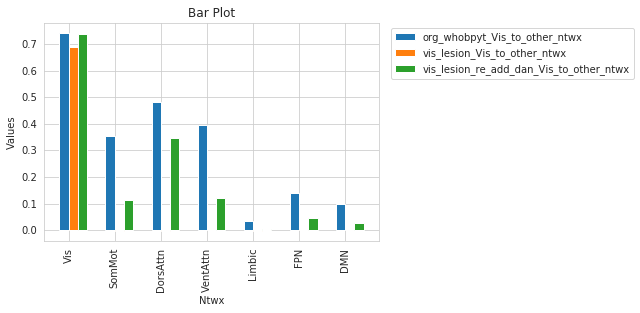

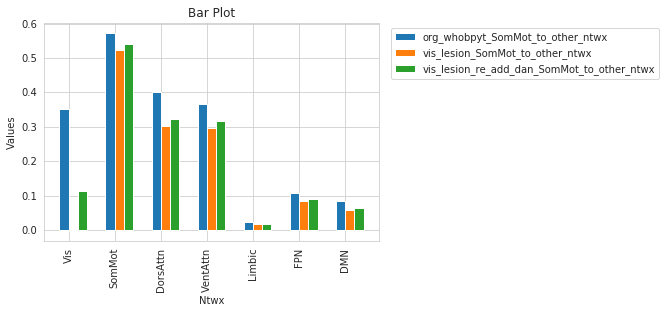

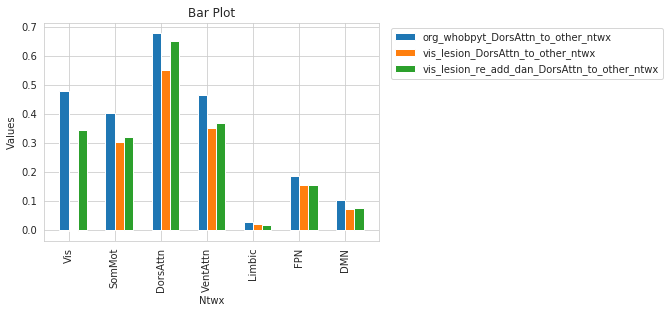

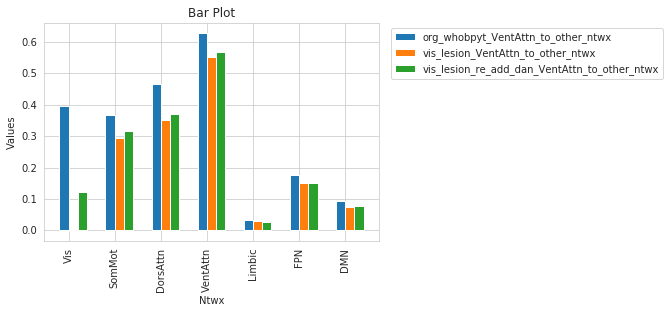

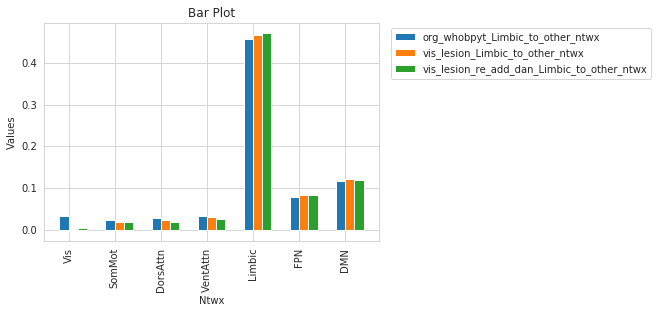

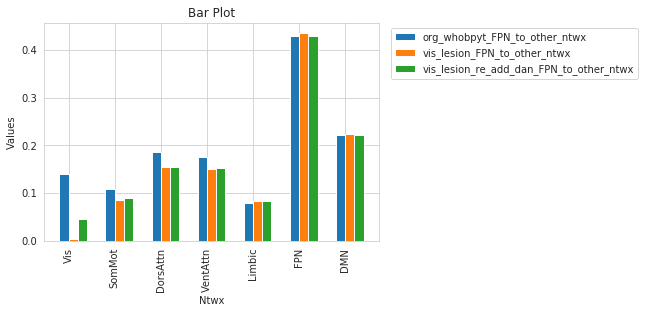

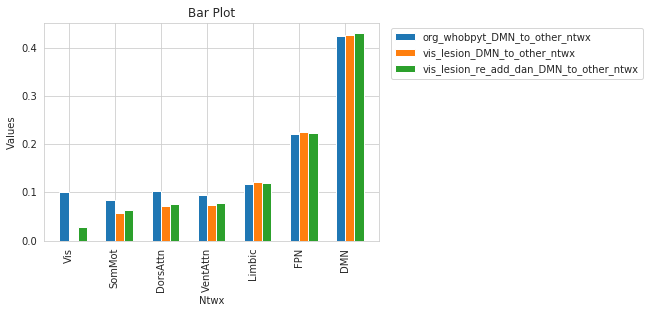

In [127]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], vis_lesion_re_add_outer_to_other_ntwx[j], width, label='vis_lesion_re_add_dan_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

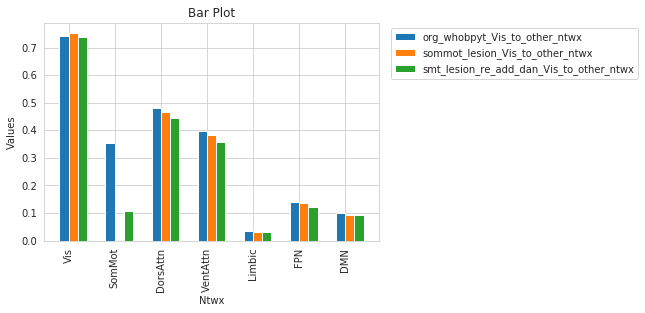

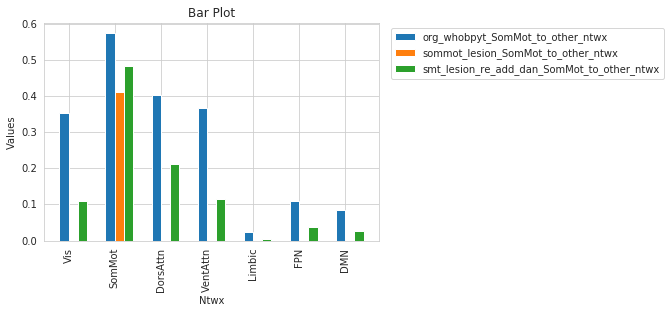

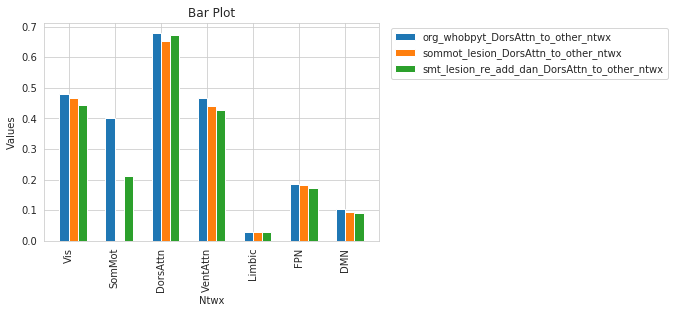

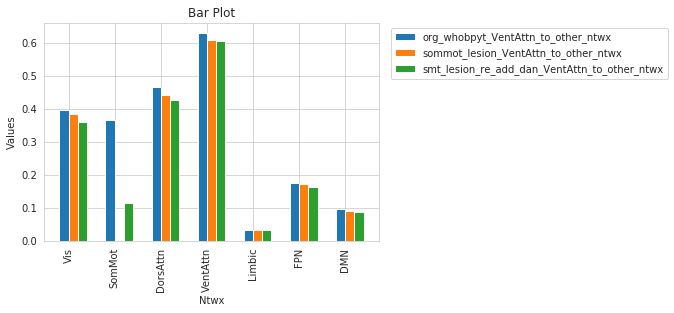

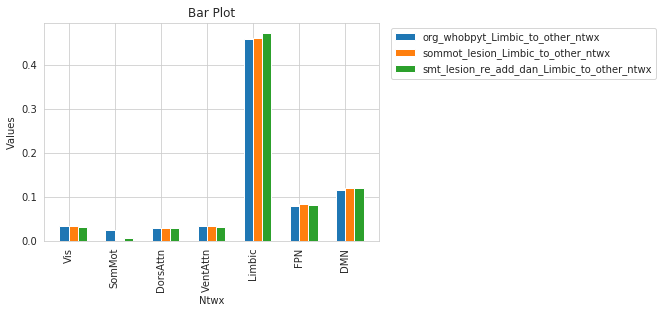

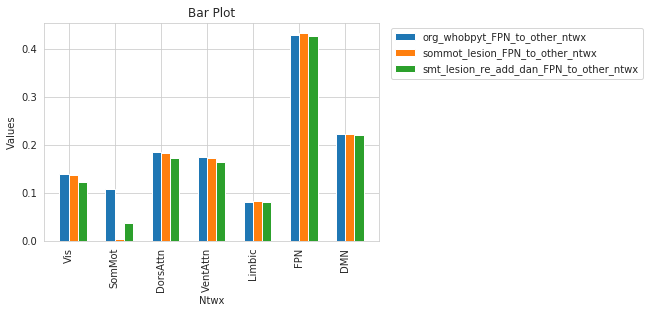

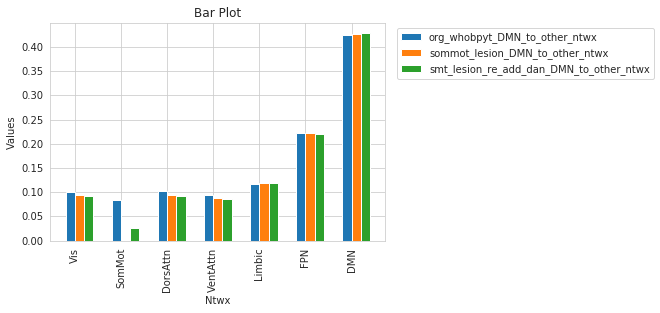

In [128]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], smt_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], smt_lesion_re_add_outer_to_other_ntwx[j], width, label='smt_lesion_re_add_dan_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DorsAttn

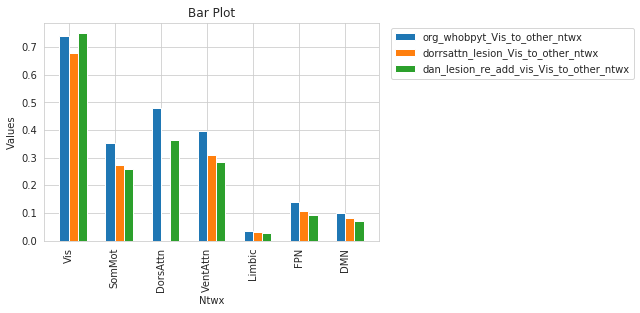

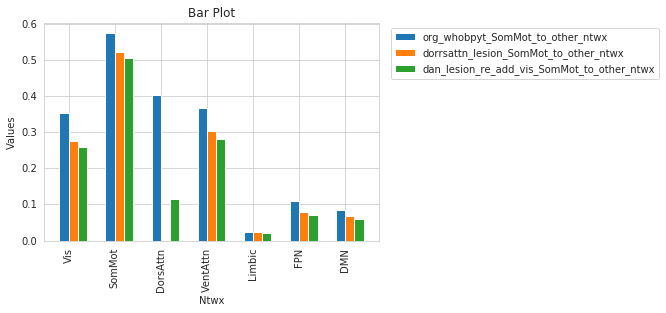

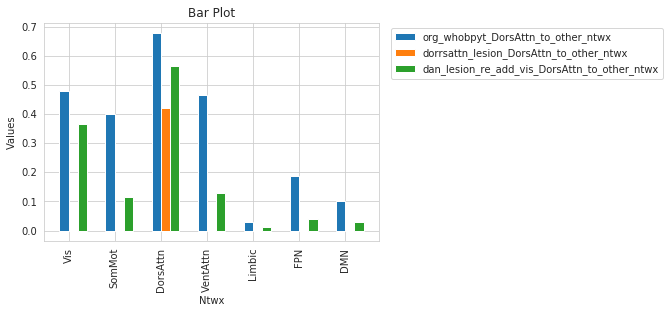

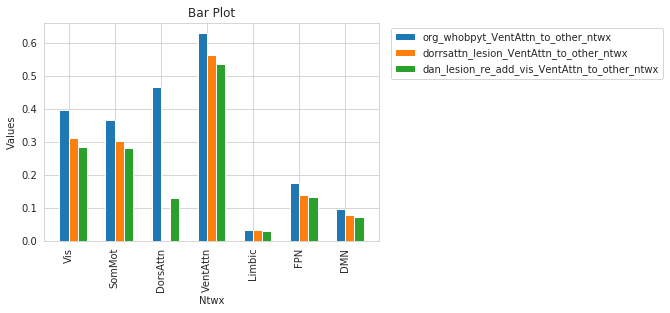

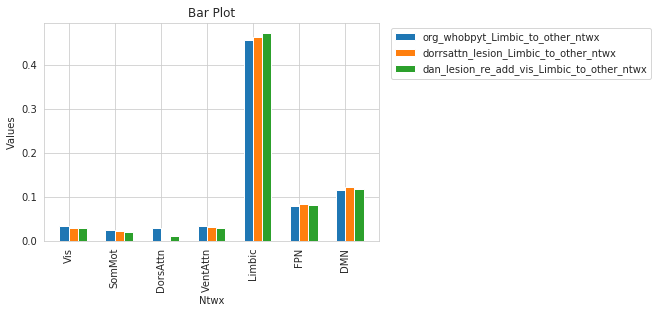

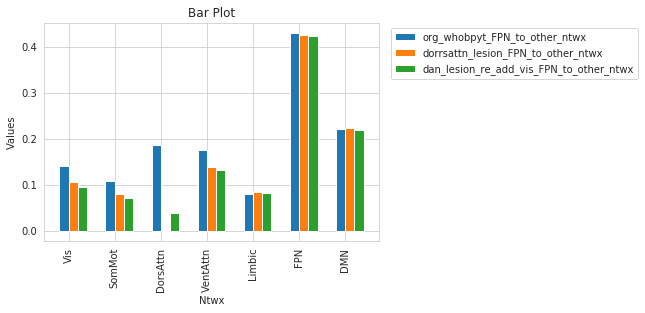

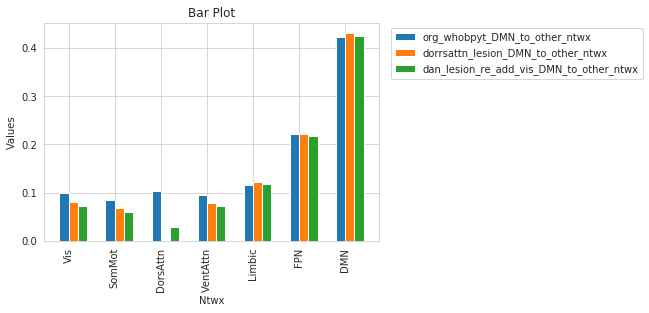

In [129]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dan_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], dan_lesion_re_add_outer_to_other_ntwx[j], width, label='dan_lesion_re_add_vis_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VentAttn

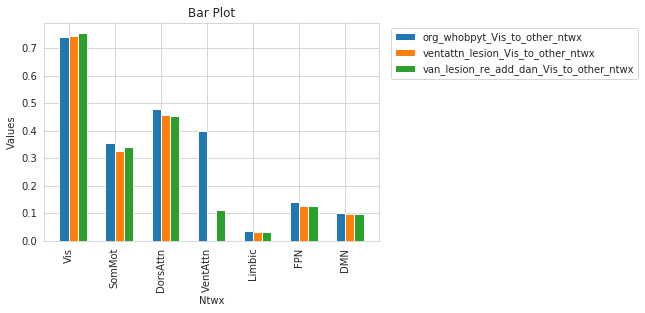

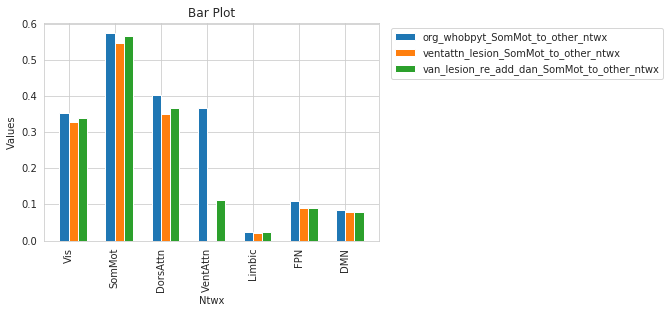

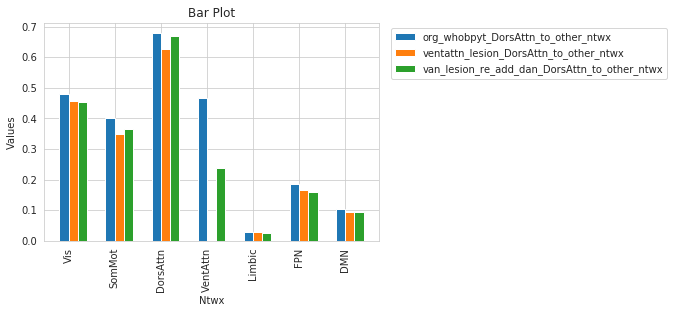

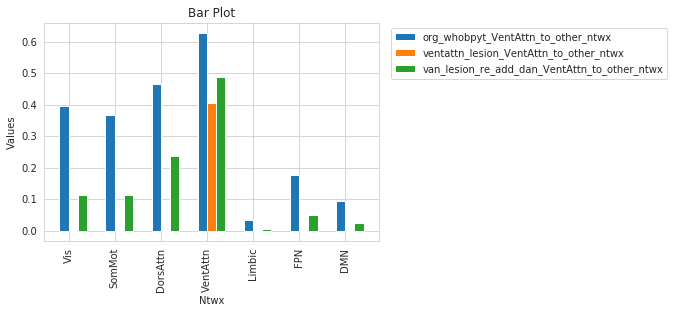

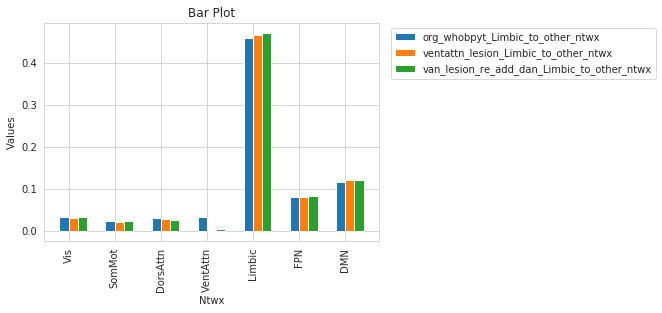

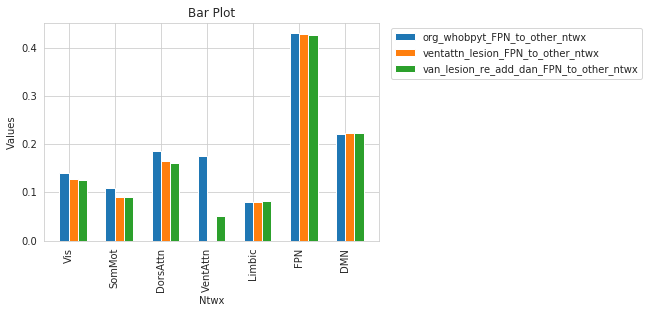

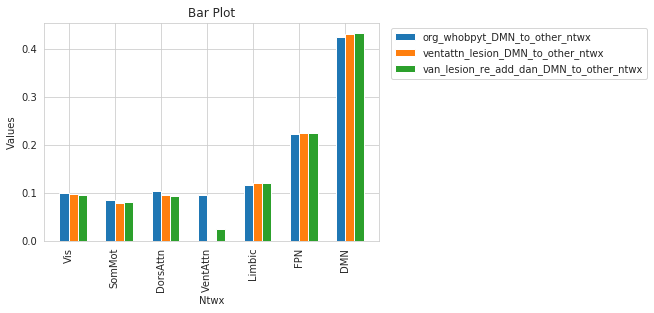

In [130]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], van_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], van_lesion_re_add_outer_to_other_ntwx[j], width, label='van_lesion_re_add_dan_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

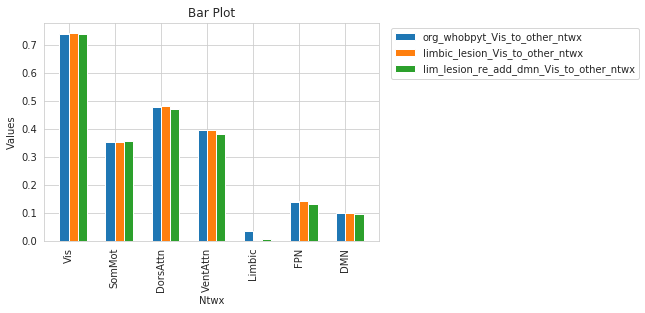

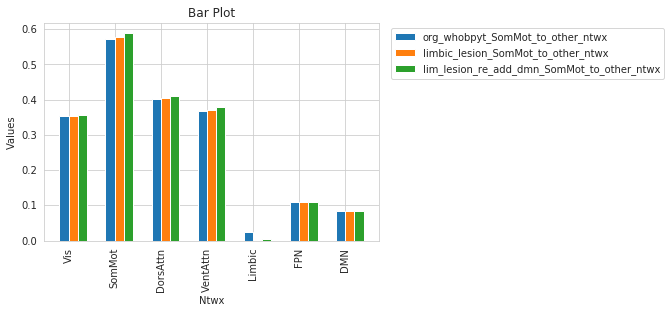

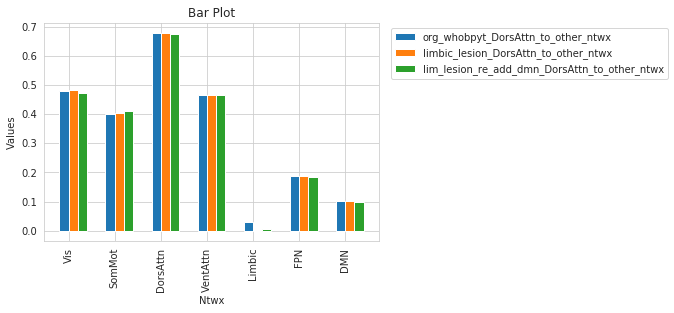

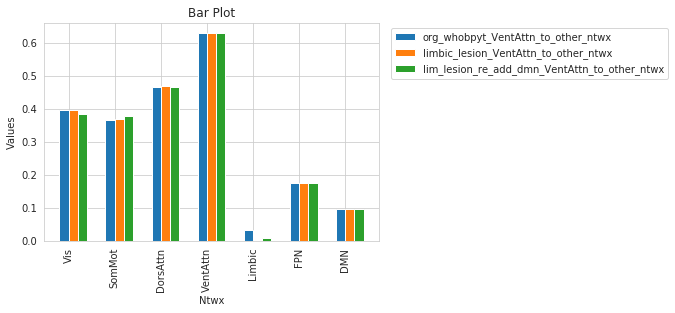

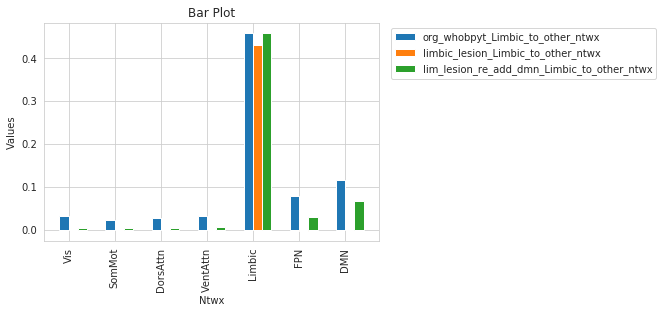

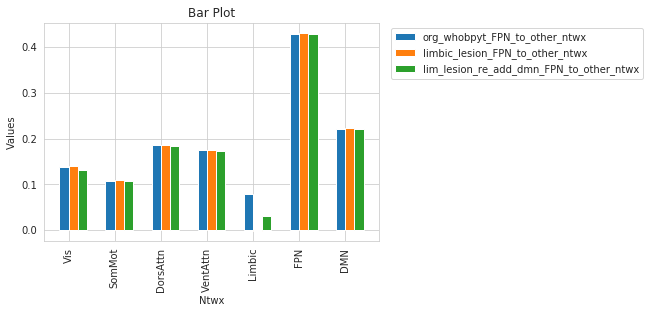

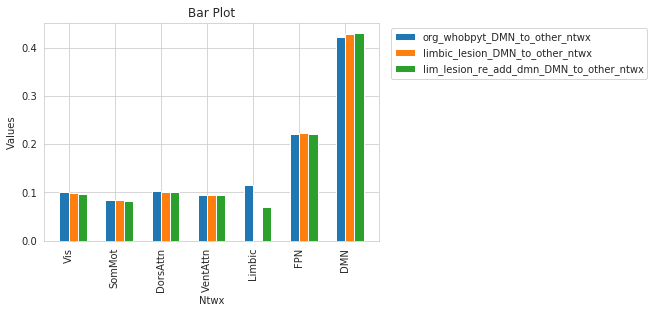

In [131]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], lim_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], lim_lesion_re_add_outer_to_other_ntwx[j], width, label='lim_lesion_re_add_dmn_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

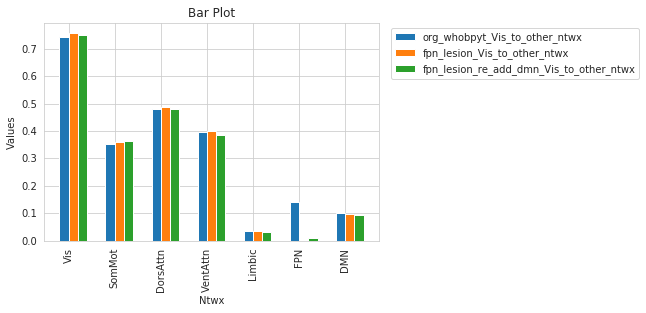

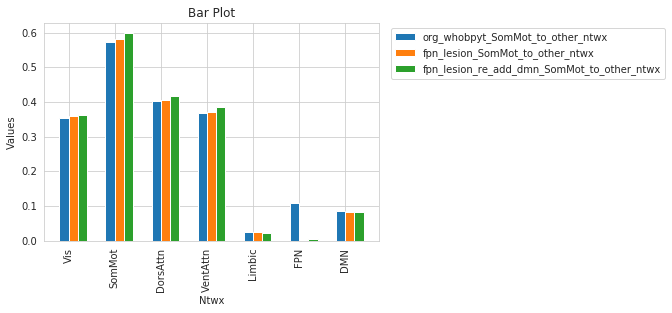

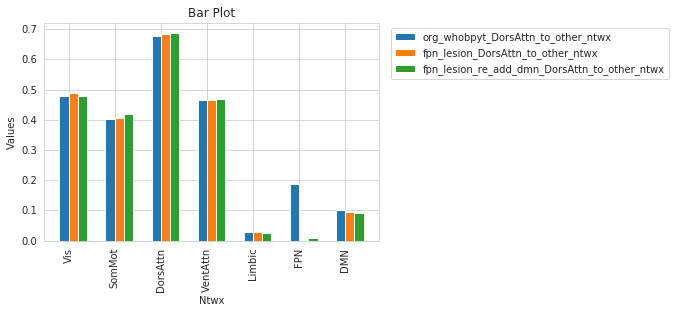

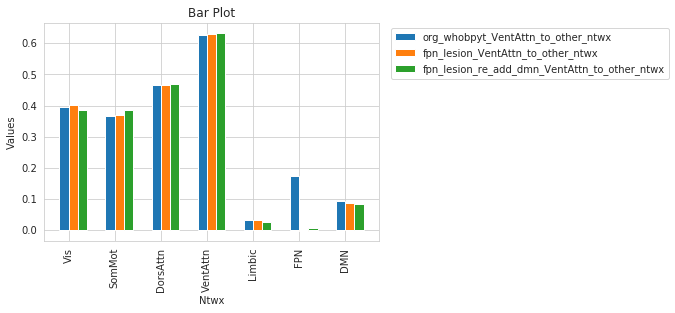

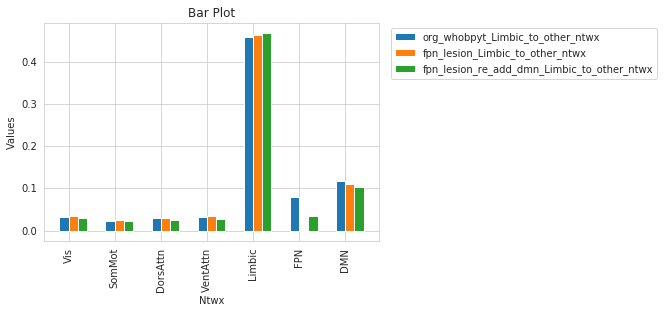

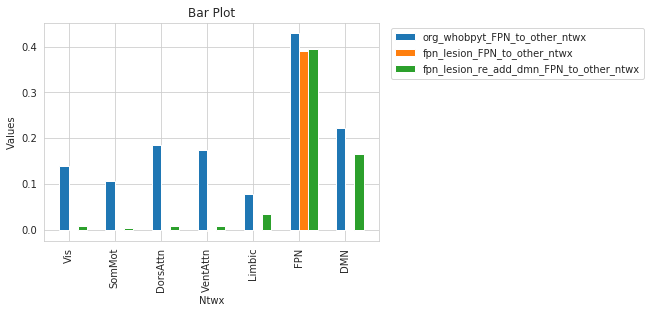

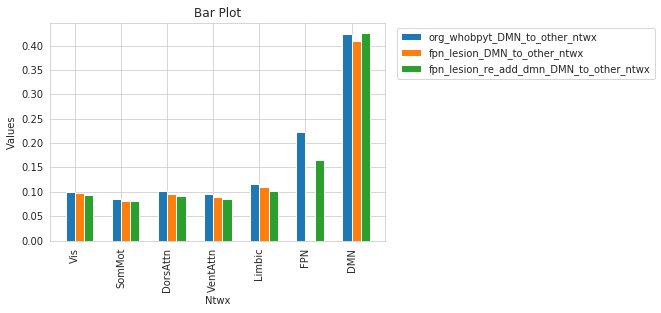

In [132]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], fpn_lesion_re_add_outer_to_other_ntwx[j], width, label='fpn_lesion_re_add_dmn_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

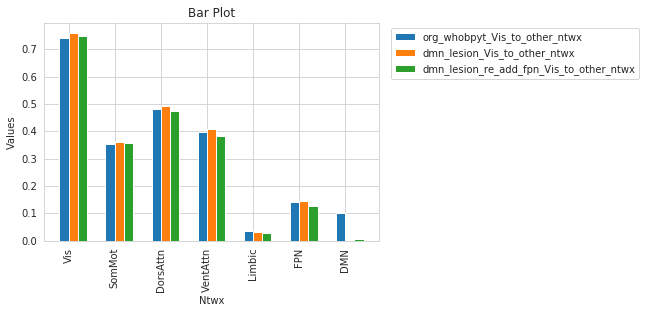

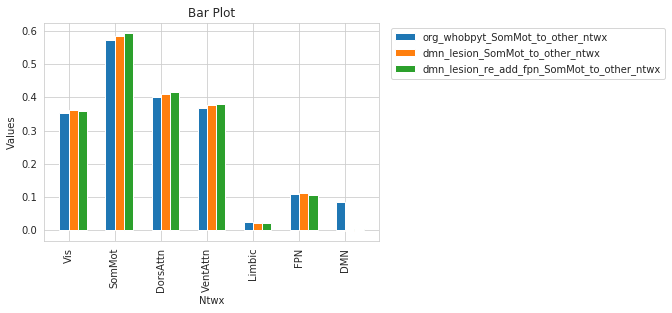

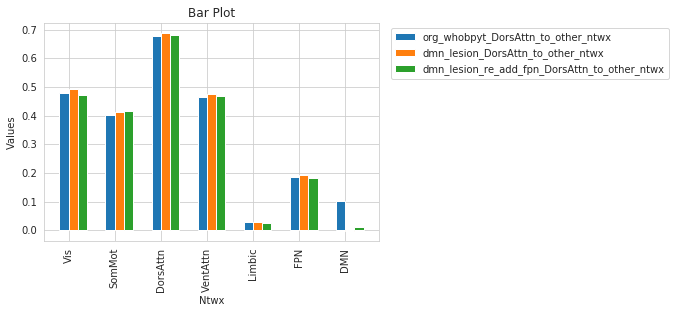

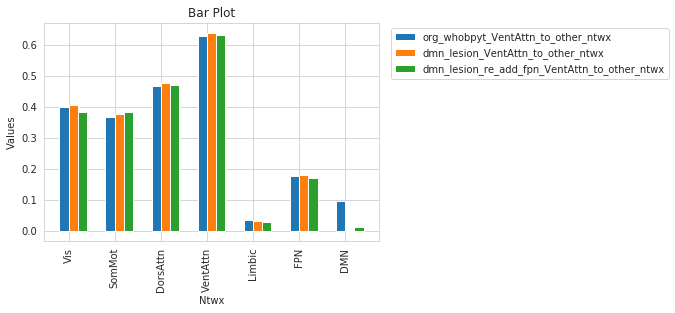

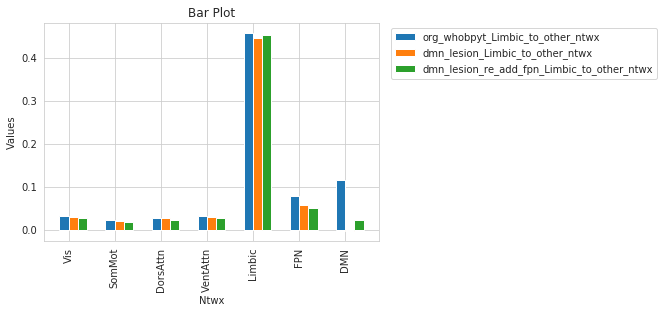

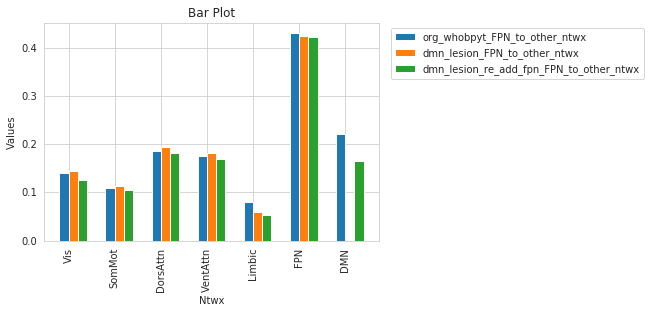

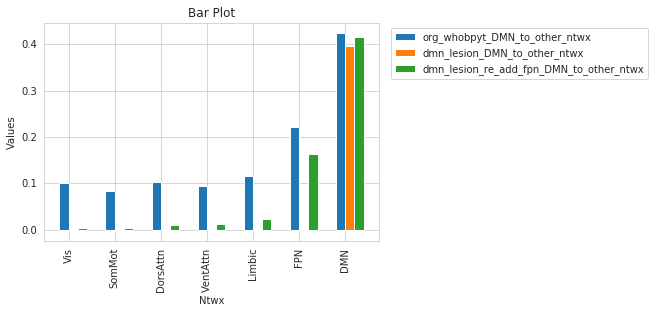

In [133]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
#     width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects3 = ax.bar([i + 2*width for i in x], dmn_lesion_re_add_outer_to_other_ntwx[j], width, label='dmn_lesion_re_add_fpn_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

## ---------------------------------------------------------------------------------------------------------------------------------

## Stats

### `vis` Lesion + re_add Stats

In [134]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(vis_lesion_all_subs_outer_to_other_ntwx[i], vis_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ -1.74941213  -8.58310633 -21.2840534   -9.33615491  -3.04612133
  -6.70670157  -5.44954738]
[8.09905633e-02 2.09889461e-16 1.14111445e-67 7.15519783e-19
 2.47247496e-03 6.84860315e-11 8.87043330e-08]
['0.0809905633', '0.0000000000', '0.0000000000', '0.0000000000', '0.0024724750', '0.0000000001', '0.0000000887']
--------------------- 

SomMot to other ntwx stats 

[-8.58310633 -0.80475768 -0.74849827 -0.95204146  0.24941753 -0.40881747
 -0.81221759]
[2.09889461e-16 4.21439988e-01 4.54601756e-01 3.41653762e-01
 8.03166497e-01 6.82893501e-01 4.17152318e-01]
['0.0000000000', '0.4214399881', '0.4546017556', '0.3416537623', '0.8031664971', '0.6828935014', '0.4171523180']
--------------------- 

DorsAttn to other ntwx stats 

[-2.12840534e+01 -7.48498268e-01 -4.50499776e+00 -6.94367430e-01
  9.73387533e-01  9.78734083e-03 -5.63882491e-01]
[1.14111445e-67 4.54601756e-01 8.73541426e-06 4.87856925e-01
 3.30951947e-01 9.92195860e-01 5.73151695e-01]
['0.0000000000', '0.

### `smt` Lesion + re_add Stats

In [135]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(smt_lesion_all_subs_outer_to_other_ntwx[i], smt_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 0.79036213 -8.04432589  1.0364927   1.14670725  0.13236583  1.12887753
  0.22339922]
[4.29786984e-01 1.00575942e-14 3.00601669e-01 2.52191541e-01
 8.94761832e-01 2.59629469e-01 8.23339428e-01]
['0.4297869836', '0.0000000000', '0.3006016693', '0.2521915415', '0.8947618317', '0.2596294689', '0.8233394279']
--------------------- 

SomMot to other ntwx stats 

[ -8.04432589  -2.99181885 -12.30179409  -8.65218961  -2.41064752
  -7.07975526  -5.58299245]
[1.00575942e-14 2.94583220e-03 1.06687994e-29 1.26255722e-16
 1.63766954e-02 6.57458102e-12 4.38325962e-08]
['0.0000000000', '0.0029458322', '0.0000000000', '0.0000000000', '0.0163766954', '0.0000000000', '0.0000000438']
--------------------- 

DorsAttn to other ntwx stats 

[  1.0364927  -12.30179409  -1.01183467   0.66792981   0.40591829
   0.85359546   0.35047701]
[3.00601669e-01 1.06687994e-29 3.12231839e-01 5.04565530e-01
 6.85020782e-01 3.93842615e-01 7.26166157e-01]
['0.3006016693', '0.0000000000', '0.31223

### `dan` Lesion + re_add Stats

In [136]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(dan_lesion_all_subs_outer_to_other_ntwx[i], dan_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ -3.6595365    0.69600159 -21.2882721    1.17198159   0.23894633
   1.09514108   0.98938574]
[2.86702463e-04 4.86834057e-01 1.09408723e-67 2.41905516e-01
 8.11270189e-01 2.74117108e-01 3.23075555e-01]
['0.0002867025', '0.4868340572', '0.0000000000', '0.2419055162', '0.8112701886', '0.2741171082', '0.3230755553']
--------------------- 

SomMot to other ntwx stats 

[ 0.69600159  0.83309634 -9.86641027  1.06545087  0.70021675  1.07065438
  0.98470146]
[4.86834057e-01 4.05290050e-01 1.09796450e-20 2.87317867e-01
 4.84201053e-01 2.84973701e-01 3.25368961e-01]
['0.4868340572', '0.4052900497', '0.0000000000', '0.2873178670', '0.4842010533', '0.2849737008', '0.3253689614']
--------------------- 

DorsAttn to other ntwx stats 

[-21.2882721   -9.86641027  -5.00053622 -10.89712192  -4.33256094
  -7.52381171  -6.51595346]
[1.09408723e-67 1.09796450e-20 8.58914373e-07 2.24832363e-24
 1.86841017e-05 3.57917585e-13 2.18705874e-10]
['0.0000000000', '0.0000000000', '0.00000

### `van` Lesion + re_add Stats

In [137]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(van_lesion_all_subs_outer_to_other_ntwx[i], van_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.60086303 -0.47257625  0.17499805 -8.74400717 -0.26138441  0.23575565
  0.02515406]
[5.48273243e-01 6.36774559e-01 8.61170155e-01 6.39838432e-17
 7.93931283e-01 8.13743551e-01 9.79944685e-01]
['0.5482732433', '0.6367745594', '0.8611701550', '0.0000000000', '0.7939312832', '0.8137435514', '0.9799446845']
--------------------- 

SomMot to other ntwx stats 

[-0.47257625 -0.86744633 -0.69158523 -8.78527986 -0.49294203 -0.02959352
 -0.11418683]
[6.36774559e-01 3.86220200e-01 4.89601058e-01 4.70674899e-17
 6.22325401e-01 9.76406065e-01 9.09147268e-01]
['0.6367745594', '0.3862202005', '0.4896010581', '0.0000000000', '0.6223254008', '0.9764060647', '0.9091472678']
--------------------- 

DorsAttn to other ntwx stats 

[  0.17499805  -0.69158523  -2.27580379 -14.21344737   0.15225241
   0.36419614   0.17256328]
[8.61170155e-01 4.89601058e-01 2.33884730e-02 2.27744437e-37
 8.79065009e-01 7.15904953e-01 8.63082435e-01]
['0.8611701550', '0.4896010581', '0.0233884730',

### `lim` Lesion + re_add Stats

In [138]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(lim_lesion_all_subs_outer_to_other_ntwx[i], lim_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 0.21686927 -0.16177031  0.50660757  0.67956451 -1.93396104  0.74220021
  0.35201097]
[0.82842135 0.87156883 0.61271073 0.49717528 0.05382655 0.45840382
 0.72501634]
['0.8284213471', '0.8715688266', '0.6127107273', '0.4971752804', '0.0538265501', '0.4584038225', '0.7250163430']
--------------------- 

SomMot to other ntwx stats 

[-0.16177031 -0.55125109 -0.29978975 -0.55504736 -1.73226941  0.11164571
  0.16818727]
[0.87156883 0.58177089 0.76449404 0.57917407 0.08400033 0.91116061
 0.86652139]
['0.8715688266', '0.5817708890', '0.7644940380', '0.5791740720', '0.0840003302', '0.9111606108', '0.8665213857']
--------------------- 

DorsAttn to other ntwx stats 

[ 0.50660757 -0.29978975  0.22465104  0.1001783  -2.48582385  0.25405844
  0.03486189]
[0.61271073 0.76449404 0.82236604 0.92025321 0.01333472 0.79958161
 0.97220735]
['0.6127107273', '0.7644940380', '0.8223660425', '0.9202532117', '0.0133347191', '0.7995816072', '0.9722073461']
--------------------- 

Ve

### `fpn` Lesion + re_add Stats

In [139]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(fpn_lesion_all_subs_outer_to_other_ntwx[i], fpn_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 0.45697875 -0.16176637  0.42077784  0.75282984  1.21191619 -3.01146777
  0.43515757]
[0.64793564 0.87157193 0.67414443 0.45199722 0.22626345 0.00276572
 0.66368393]
['0.6479356376', '0.8715719258', '0.6741444258', '0.4519972192', '0.2262634478', '0.0027657177', '0.6636839304']
--------------------- 

SomMot to other ntwx stats 

[-0.16176637 -0.89753649 -0.61938109 -0.7854033   0.4254894  -2.16866754
  0.00681009]
[0.87157193 0.36997532 0.53601972 0.43268444 0.67070992 0.03069959
 0.99456979]
['0.8715719258', '0.3699753171', '0.5360197242', '0.4326844357', '0.6707099213', '0.0306995857', '0.9945697878']
--------------------- 

DorsAttn to other ntwx stats 

[ 0.42077784 -0.61938109 -0.19295548 -0.24794179  1.0238013  -3.33880089
  0.31375884]
[0.67414443 0.53601972 0.84709226 0.80430731 0.306551   0.00092073
 0.75386859]
['0.6741444258', '0.5360197242', '0.8470922577', '0.8043073134', '0.3065509992', '0.0009207268', '0.7538685887']
--------------------- 

Ve

### `dmn` Lesion + re_add Stats

In [140]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(dmn_lesion_all_subs_outer_to_other_ntwx[i], dmn_lesion_re_add_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 0.79894867  0.14693241  1.00433322  1.26627442  0.63211439  1.49309756
 -1.65350045]
[0.42479669 0.88325977 0.31582824 0.20615548 0.52767507 0.13620394
 0.09901754]
['0.4247966887', '0.8832597660', '0.3158282362', '0.2061554758', '0.5276750685', '0.1362039383', '0.0990175403']
--------------------- 

SomMot to other ntwx stats 

[ 0.14693241 -0.4444299  -0.16386596 -0.28177677  0.5181801   0.74193189
 -2.79705514]
[0.88325977 0.65697337 0.86991985 0.77826114 0.60462056 0.4585662
 0.00540735]
['0.8832597660', '0.6569733663', '0.8699198470', '0.7782611402', '0.6046205551', '0.4585662022', '0.0054073487']
--------------------- 

DorsAttn to other ntwx stats 

[ 1.00433322 -0.16386596  0.50033533  0.53974894  0.92419099  1.101103
 -4.30683125]
[3.15828236e-01 8.69919847e-01 6.17115522e-01 5.89672035e-01
 3.55946862e-01 2.71517304e-01 2.08847229e-05]
['0.3158282362', '0.8699198470', '0.6171155216', '0.5896720346', '0.3559468618', '0.2715173040', '0.0000208847']
-